# Simple Job Shop Scheduling

This example schedules 2 jobs on 2 machines.
Each job is a sequence of operations, and each machine can process only one
operation at a time. The goal is to minimize makespan.


## Problem Description

Schedule 2 jobs on 2 machines. Each job is a fixed sequence of operations.
Each operation has a fixed machine and duration. Each machine can process
at most one operation at a time.

Objective: minimize the makespan (completion time of the last job).


## Mathematical Model

**Definitions:**

- $I_{j,o}$: interval of operation $o$ of job $j$
- $p_{j,o}$: duration
- $m_{j,o}$: machine assignment

**Constraints:**

- $end_{j,o} \le start_{j,o+1} \quad \forall j \in J, \forall o = 0..|O_j|-2$

- $\text{NoOverlap}(\{ I_{j,o} \mid m_{j,o} = m \}) \quad \forall m \in M$

**Objective:**

- $\min \max_{j \in J} end_{j,\text{last}}$

## Imports


In [1]:
# Imports
from pycsp3 import *
from pycsp3_scheduling import *  

## Problem Data


In [2]:
# Problem data: jobs[j] = [(machine, duration), ...]
jobs = {
    0: [(0, 3), (1, 2)],
    1: [(1, 4), (0, 2)],
}

job_ids = sorted(jobs)
n_jobs = len(job_ids)
n_machines = 2
n_ops = len(jobs[job_ids[0]])

machines = {j: [m for m, _ in jobs[j]] for j in job_ids}
durations = {j: [d for _, d in jobs[j]] for j in job_ids}


## Build the Model


In [3]:
clear()
from pycsp3_scheduling.variables.interval import clear_interval_registry
clear_interval_registry()

ops = {j: [] for j in job_ids}
for j in job_ids:
    for o, duration in enumerate(durations[j]):
        machine = machines[j][o]
        iv = IntervalVar(size=duration, name=f"J{j}O{o}_M{machine}")
        ops[j].append(iv)


In [4]:
# Precedence constraints within jobs
satisfy(
    end_before_start(ops[j][o], ops[j][o + 1])
    for j in job_ids
    for o in range(n_ops - 1)
)

# Group operations by machine
machine_ops = {m: [] for m in range(n_machines)}
for j in job_ids:
    for o in range(n_ops):
        m = machines[j][o]
        machine_ops[m].append(ops[j][o])

sequences = {
    m: SequenceVar(intervals=machine_ops[m], name=f"machine{m}")
    for m in range(n_machines)
}

satisfy(SeqNoOverlap(sequences[m]) for m in range(n_machines))


noOverlap(origins:[iv_s_0, iv_s_3], lengths:[3, 2])
noOverlap(origins:[iv_s_1, iv_s_2], lengths:[2, 4])

In [5]:
objective_expr = Maximum(end_time(ops[j][-1]) for j in job_ids)
minimize(objective_expr)


## Solve


In [6]:
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found." + (" (Optimal)" if result == OPTIMUM else ""))
    for j in job_ids:
        print(f"Job {j}:")
        for o in range(n_ops):
            val = interval_value(ops[j][o])
            m = machines[j][o]
            print(f"  Op {o} on M{m}: [{val.start}, {val.end})")
    makespan = max(interval_value(ops[j][-1]).end for j in job_ids)
    print(f"Makespan: {makespan}")
else:
    print("No solution found.")


Solution found. (Optimal)
Job 0:
  Op 0 on M0: [0, 3)
  Op 1 on M1: [4, 6)
Job 1:
  Op 0 on M1: [0, 4)
  Op 1 on M0: [4, 6)
Makespan: 6


## Stats


In [7]:
print("Model statistics:", model_statistics())
if result in (SAT, OPTIMUM):
    objective_value = globals().get("makespan")
    print("Solution statistics:", solution_statistics(status=result, objective=objective_value))


Model statistics: ModelStatistics(nb_interval_vars=4, nb_optional_interval_vars=0, nb_sequences=2, nb_sequences_with_types=0, nb_cumul_functions=0, nb_state_functions=0)
Solution statistics: SolutionStatistics(status=OPTIMUM, objective_value=6, solve_time=None, nb_interval_vars=4, nb_intervals_present=4, nb_intervals_absent=0, min_start=0, max_end=6, makespan=6, span=6)


## Visualization


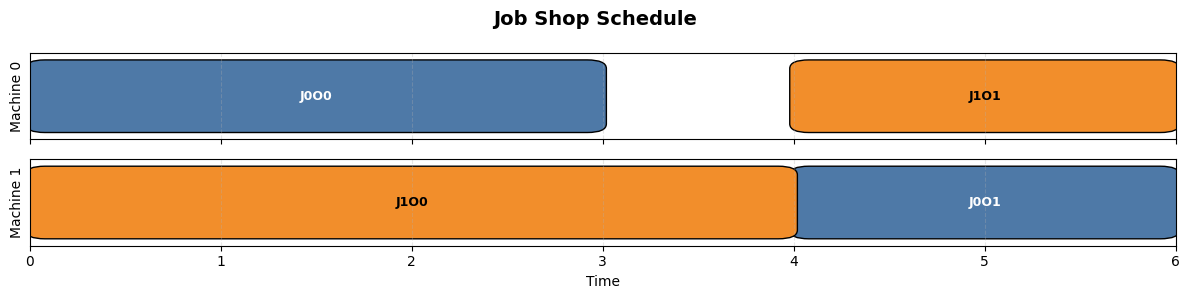

In [8]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(ops[j][-1]).end for j in job_ids)
    visu.timeline("Job Shop Schedule", origin=0, horizon=makespan)

    for m in range(n_machines):
        visu.panel(f"Machine {m}")
        for j in job_ids:
            for o in range(n_ops):
                if machines[j][o] == m:
                    val = interval_value(ops[j][o])
                    visu.interval(val.start, val.end, f"J{j}O{o}", color=j)

    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available).")
